In [24]:
import numpy as np
from scipy.sparse import spdiags, csr_matrix
import matplotlib.pyplot as plt
from numba import njit, prange, stencil
from sympy import *
from scipy.interpolate import interp1d
from scipy.sparse.linalg import spsolve
from scipy.linalg import norm

The models in this notebook will follow a novel joint inversion approach. The models for CA and NY will use the energy share of Federal emissions and the energy sector emissions growth to define the prior model for the regression of expected emissions up to a given date. 

$$
Prior = InverseModel(CO_{2}_{State}/CO_2_{Fed}, d/dt (EnergySector))
$$

This prior model will assume 10 percent error in all mesurements and feed the direct regression of the actual data. 

The similarity between the direct regression and the inverse model will define the significance of legislation. 

In [48]:
Years = np.arange(1970, 2020)
CAE = np.genfromtxt('Electric_power_carbon_dioxide_emissions_all_fuels_California.csv', delimiter=',', skip_header=5)[:, 1]
NYE = np.genfromtxt('Electric_power_carbon_dioxide_emissions_all_fuels_New_York.csv', delimiter=',', skip_header=5)[:, 1]
USE = np.genfromtxt('Electric_power_carbon_dioxide_emissions_all_fuels_United_States.csv', delimiter=',', skip_header=5)[:, 1]
CATot = np.genfromtxt('Total_carbon_dioxide_emissions_from_all_sectors_all_fuels_California.csv', delimiter=',', skip_header=5)[:, 1]
NYTot = np.genfromtxt('Total_carbon_dioxide_emissions_from_all_sectors_all_fuels_New_York.csv', delimiter=',', skip_header=5)[:, 1]
USTot = np.genfromtxt('Total_carbon_dioxide_emissions_from_all_sectors_all_fuels_United_States.csv', delimiter=',', skip_header=5)[:, 1]

In [51]:
CAShare = CATot/USTot *5500
NYShare = NYTot/USTot *5500

CAShare = np.flip(CAShare)
NYShare = np.flip(NYShare)
CATot = np.flip(CATot)
NYTot = np.flip(NYTot)


year1 = NYShare[0]
yearLast = NYShare[-1]
year2 = NYShare[1]
year2L = NYShare[-2]

Years1 = Years[:-9]
CAShare1 = CAShare[:-9]
NYShare1 = NYShare[:-9]

@stencil
def smoothing(Mat):
    return(Mat[-1] + Mat[0] + Mat[1] + Mat[-2] + Mat[2])/5
    
NYShare = smoothing(NYShare1)
NYShare[0] = year1
NYShare[-1] = yearLast
NYShare[-2] = year2L
NYShare[1] = year2

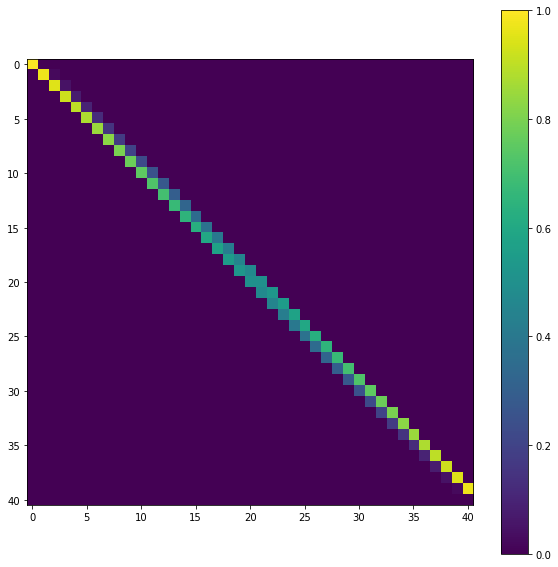

In [52]:
def linop1D(xd, nx, ox, dx):
    nd = len(xd)
    jd = np.arange(0,nd,1)
    
    d1 = (xd-ox)/dx
    i1 = np.int64(np.floor(d1))
    f1 = d1 - i1
    
    jd = np.concatenate((jd, jd))
    jm = np.concatenate((i1, i1+1))
    fm = np.concatenate((1-f1, f1))
    
    indx = (jm >= 0) & (jm < nx)
    jd = jd[indx]
    jm = jm[indx]
    fm = fm[indx]
    
    return csr_matrix((fm, (jd, jm)), shape = (nd, nx))

xmin, xmax = min(Years1), max(Years1)
nx = len(Years1)
dx = (xmax - xmin)/nx

K = linop1D(Years1, nx, xmin, dx).toarray()

plt.figure(figsize = (10,10))
plt.imshow(K)
plt.colorbar()
plt.show()

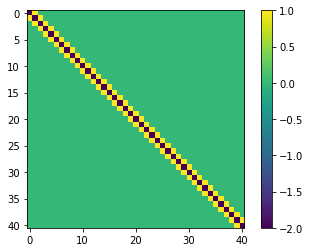

In [53]:
def lapop1D(n, w = 1):
    e = w * np.ones(n)
    Lopr = spdiags([e, -2*e, e], [-1, 0, +1], n,n)
    return Lopr

R = lapop1D(len(Years1)).toarray()

plt.imshow(R)
plt.colorbar()

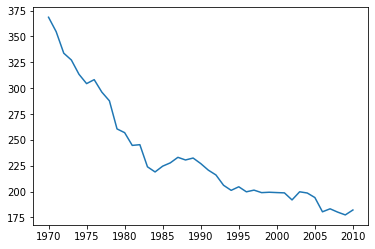

In [54]:
CARef = CAShare1
NYRef = NYShare1

plt.plot(Years1, NYShare1)

In [55]:
WD = np.diag(np.ones(len(Years1))/0.05)

##Here change state to change model
sD = np.ones(len(Years1))/0.05
sMmin = 0.0001
sMmax = 100
sM = np.linspace(sMmin,sMmax, 1000)
mbar = NYRef

##Define mTilde
@njit
def makem(K, WD, sigm, R, d, mbar):
    WM = (1/sigm)*R.T@R
    invTerm = K.T@WD.T@WD@K + WM.T@WM
    Term = K.T@WD.T@WD@d + WM.T@WM@mbar
    return invTerm, Term

In [56]:
##something here is not right but I dunno

@njit
def ModelFit(WD, K, m, IntHorizon):
    inner = WD@(K@m - IntHorizon)
    return inner
    
@njit 
def damp(sigm, R, m, mbar):
    inner = R@(m - mbar)
    return inner

In [57]:
marray = np.zeros((len(mbar), len(sM)))
d = NYTot[:-9]

for i in range(len(sM)):
    t1, t2 = makem(K, WD, sM[i], R, d, mbar)
    x = spsolve(csr_matrix(t1), t2)
    marray[:, i] = x
    
modelArr = np.zeros(len(sM))
dampArr = np.zeros(len(sM))

for i in range(len(sM)):
    modelArr[i] = norm(ModelFit(WD, K, marray[:, i], d))**2
    dampArr[i] = norm(damp(sM[i], R, marray[:, i], mbar))**2

<ipython-input-55-bd7fd8b894ab>:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Term = K.T@WD.T@WD@d + WM.T@WM@mbar
C:\Users\ryanc\anaconda3\lib\site-packages\numba\core\typing\npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
<ipython-input-56-20557068e1c7>:5: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  inner = WD@(K@m - IntHorizon)
C:\Users\ryanc\anaconda3\lib\site-packages\numba\core\typing\npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


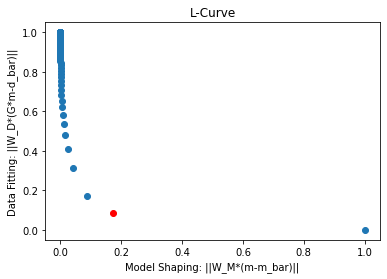

In [58]:
modelArr = modelArr - np.min(modelArr)
modelArr = modelArr/np.max(modelArr)
dampArr = dampArr - np.min(dampArr)
dampArr = dampArr/np.max(dampArr)

dist = np.zeros(len(modelArr))
for i in range(len(modelArr)):
    dist[i] = np.sqrt(modelArr[i]**2 + dampArr[i]**2)
    
optimal = min(dist)
optimi = [i for i in range(len(dist)) if dist[i]==optimal]
optimi = optimi[0]

plt.figure()
plt.scatter(modelArr,dampArr)
plt.scatter(dampArr[optimi],modelArr[optimi],c = 'r')
plt.ylabel('Data Fitting: ||W_D*(G*m-d_bar)||')
plt.xlabel('Model Shaping: ||W_M*(m-m_bar)||')
plt.title('L-Curve')
plt.show()

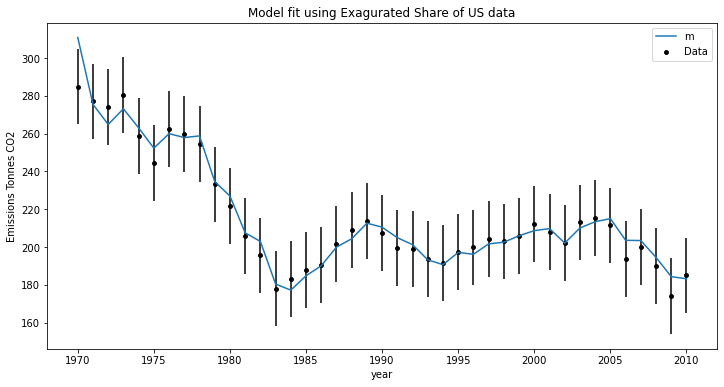

In [59]:
plt.figure(figsize = (12,6))
plt.plot(Years1, marray[:, optimi], label="m")
plt.scatter(Years1, NYTot[:-9], label = 'Data', c = 'k', s = 15)
plt.errorbar(Years1, NYTot[:-9], yerr = np.ones(len(Years1))/0.05, c = 'k', fmt='none')
#plt.plot(Years, CAShare, label = '$\\bar{m}$')
plt.legend()
plt.title('Model fit using Exagurated Share of US data')
plt.ylabel('Emissions Tonnes CO2')
plt.xlabel('year')
plt.show()

NYModel1 = marray[:, optimi]

This is the model of projected emissions over the whole time frame using share of US vertically exagurated by 5500 as the prior model to smooth towards. 

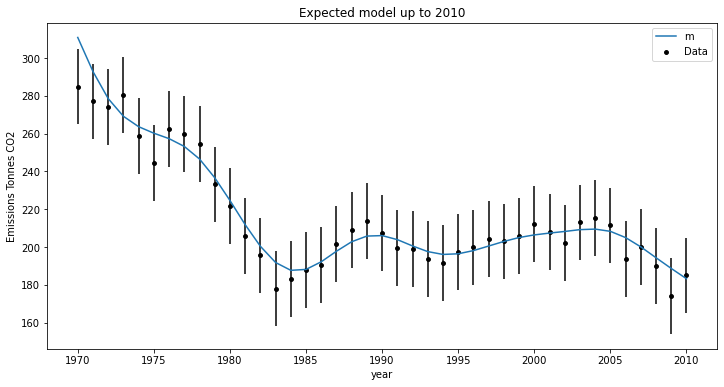

In [63]:
@stencil
def Smooth1(MAT):
    return 1/3*(MAT[-1] + MAT[0] + MAT[1])

start = NYModel1[0]
end = NYModel1[-1]

NYModel1 = Smooth1(NYModel1)

NYModel1[0] = start
NYModel1[-1] = end

start = NYModel1[0]
end = NYModel1[-1]

NYModel1 = Smooth1(NYModel1)

NYModel1[0] = start
NYModel1[-1] = end

plt.figure(figsize = (12,6))
plt.plot(Years1, NYModel1, label="m")
plt.scatter(Years1, NYTot[:-9], label = 'Data', c = 'k', s = 15)
plt.errorbar(Years1, NYTot[:-9], yerr = np.ones(len(Years1))/0.05, c = 'k', fmt='none')
#plt.plot(Years, CAShare, label = '$\\bar{m}$')
plt.legend()
plt.title('Expected model up to 2010')
plt.ylabel('Emissions Tonnes CO2')
plt.xlabel('year')
plt.show()

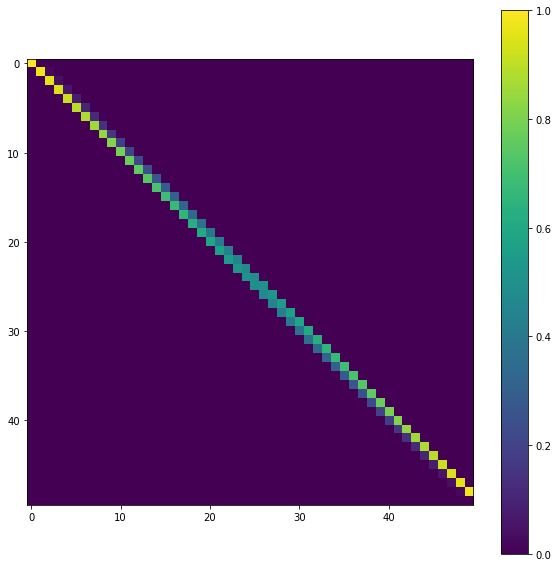

<ipython-input-68-14a95f727b4a>:82: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Term = K.T@WD.T@WD@d + WM.T@WM@mbar
C:\Users\ryanc\anaconda3\lib\site-packages\numba\core\typing\npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
<ipython-input-68-14a95f727b4a>:89: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  inner = WD@(K@m - IntHorizon)
C:\Users\ryanc\anaconda3\lib\site-packages\numba\core\typing\npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


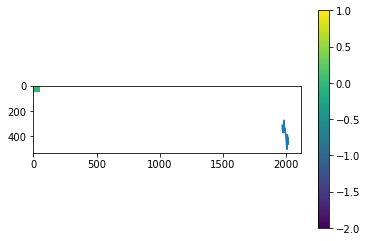

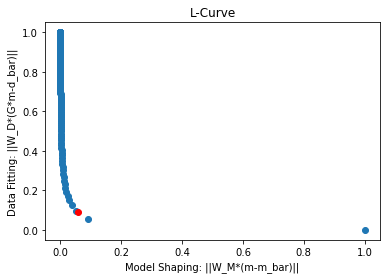

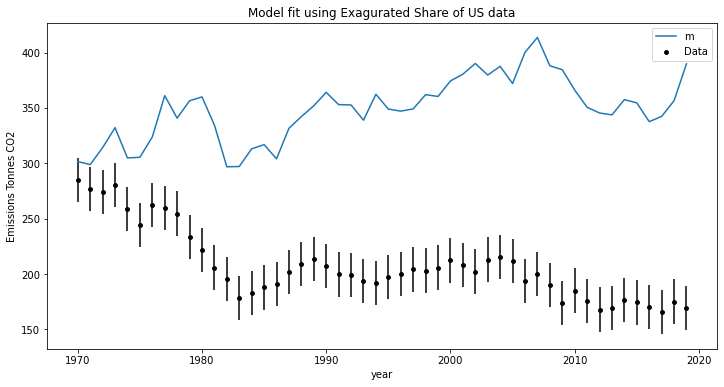

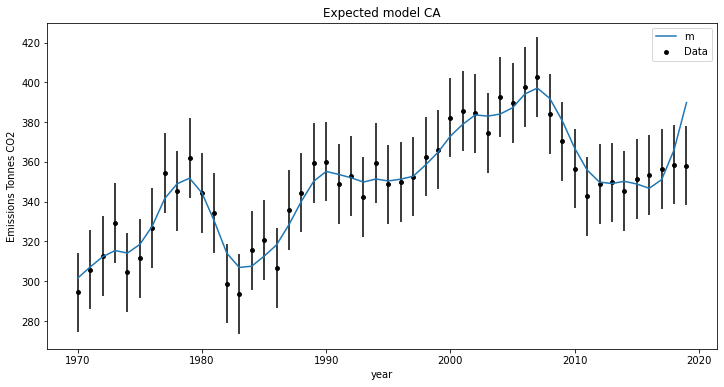

In [68]:
CAShare = CATot/USTot *5500
NYShare = NYTot/USTot *5500

year1 = CAShare[0]
yearLast = CAShare[-1]
year2 = CAShare[1]
year2L = CAShare[-2]

Years = Years
CAShare = CAShare
NYShare = NYShare

@stencil
def smoothing(Mat):
    return(Mat[-1] + Mat[0] + Mat[1] + Mat[-2] + Mat[2])/5
    
NYShare = smoothing(CAShare)
NYShare[0] = year1
NYShare[-1] = yearLast
NYShare[-2] = year2L
NYShare[1] = year2

def linop1D(xd, nx, ox, dx):
    nd = len(xd)
    jd = np.arange(0,nd,1)
    
    d1 = (xd-ox)/dx
    i1 = np.int64(np.floor(d1))
    f1 = d1 - i1
    
    jd = np.concatenate((jd, jd))
    jm = np.concatenate((i1, i1+1))
    fm = np.concatenate((1-f1, f1))
    
    indx = (jm >= 0) & (jm < nx)
    jd = jd[indx]
    jm = jm[indx]
    fm = fm[indx]
    
    return csr_matrix((fm, (jd, jm)), shape = (nd, nx))

xmin, xmax = min(Years), max(Years)
nx = len(Years)
dx = (xmax - xmin)/nx

K = linop1D(Years, nx, xmin, dx).toarray()

plt.figure(figsize = (10,10))
plt.imshow(K)
plt.colorbar()
plt.show()

def lapop1D(n, w = 1):
    e = w * np.ones(n)
    Lopr = spdiags([e, -2*e, e], [-1, 0, +1], n,n)
    return Lopr

R = lapop1D(len(Years)).toarray()

plt.imshow(R)
plt.colorbar()

CARef = CAShare
NYRef = NYShare

plt.plot(Years, CAShare)

WD = np.diag(np.ones(len(Years))/0.05)

##Here change state to change model
sD = np.ones(len(Years))/0.05
sMmin = 0.0001
sMmax = 100
sM = np.linspace(sMmin,sMmax, 1000)
mbar = CARef

##Define mTilde
@njit
def makem(K, WD, sigm, R, d, mbar):
    WM = (1/sigm)*R.T@R
    invTerm = K.T@WD.T@WD@K + WM.T@WM
    Term = K.T@WD.T@WD@d + WM.T@WM@mbar
    return invTerm, Term

##something here is not right but I dunno

@njit
def ModelFit(WD, K, m, IntHorizon):
    inner = WD@(K@m - IntHorizon)
    return inner
    
@njit 
def damp(sigm, R, m, mbar):
    inner = R@(m - mbar)
    return inner

marray = np.zeros((len(mbar), len(sM)))
d = CATot

for i in range(len(sM)):
    t1, t2 = makem(K, WD, sM[i], R, d, mbar)
    x = spsolve(csr_matrix(t1), t2)
    marray[:, i] = x
    
modelArr = np.zeros(len(sM))
dampArr = np.zeros(len(sM))

for i in range(len(sM)):
    modelArr[i] = norm(ModelFit(WD, K, marray[:, i], d))**2
    dampArr[i] = norm(damp(sM[i], R, marray[:, i], mbar))**2
    
modelArr = modelArr - np.min(modelArr)
modelArr = modelArr/np.max(modelArr)
dampArr = dampArr - np.min(dampArr)
dampArr = dampArr/np.max(dampArr)

dist = np.zeros(len(modelArr))
for i in range(len(modelArr)):
    dist[i] = np.sqrt(modelArr[i]**2 + dampArr[i]**2)
    
optimal = min(dist)
optimi = [i for i in range(len(dist)) if dist[i]==optimal]
optimi = optimi[0]

plt.figure()
plt.scatter(modelArr,dampArr)
plt.scatter(dampArr[optimi],modelArr[optimi],c = 'r')
plt.ylabel('Data Fitting: ||W_D*(G*m-d_bar)||')
plt.xlabel('Model Shaping: ||W_M*(m-m_bar)||')
plt.title('L-Curve')
plt.show()

plt.figure(figsize = (12,6))
plt.plot(Years, marray[:, optimi], label="m")
plt.scatter(Years, NYTot, label = 'Data', c = 'k', s = 15)
plt.errorbar(Years, NYTot, yerr = np.ones(len(Years))/0.05, c = 'k', fmt='none')
#plt.plot(Years, CAShare, label = '$\\bar{m}$')
plt.legend()
plt.title('Model fit using Exagurated Share of US data')
plt.ylabel('Emissions Tonnes CO2')
plt.xlabel('year')
plt.show()

NYModel = marray[:, optimi]

@stencil
def Smooth1(MAT):
    return 1/3*(MAT[-1] + MAT[0] + MAT[1])

start = NYModel[0]
end = NYModel[-1]

NYModel = Smooth1(NYModel)

NYModel[0] = start
NYModel[-1] = end

start = NYModel[0]
end = NYModel[-1]

NYModel = Smooth1(NYModel)

NYModel[0] = start
NYModel[-1] = end

plt.figure(figsize = (12,6))
plt.plot(Years, NYModel, label="m")
plt.scatter(Years, CATot, label = 'Data', c = 'k', s = 15)
plt.errorbar(Years, CATot, yerr = np.ones(len(Years))/0.05, c = 'k', fmt='none')
#plt.plot(Years, CAShare, label = '$\\bar{m}$')
plt.legend()
plt.title('Expected model CA')
plt.ylabel('Emissions Tonnes CO2')
plt.xlabel('year')
plt.show()

1.3828820651296878


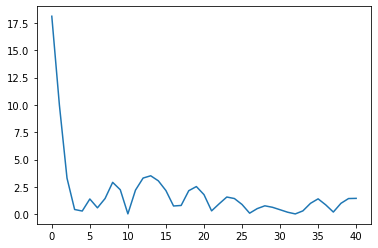

In [66]:
diff = np.abs(NYModel[:-9] - NYModel1)

plt.plot(diff)

RMS = np.sum(diff)/len(diff)
RMS = np.sqrt(RMS)
print(RMS)